In [37]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

sys.path.append('../')

from src_experiment import NeuralNet, moon_path, wbc_path, get_moons_data, get_wbc_data, train_model
from geobin import RegionTree, TreeNode

In [38]:
hidden_sizes = [7,7,7]
num_classes = 1
model = NeuralNet(
    input_size = 30,
    hidden_sizes = hidden_sizes,
    num_classes = num_classes,
)


# Data
train_data, test_data = get_wbc_data(label_noise=0.0, batch_size=32)

epochs = 50
save_for_epochs = [0,3,6,9,15,25,35,49]


In [39]:
res, states = train_model(
    model=model,
    train_data = train_data,
    test_data = test_data,
    epochs = epochs,
    # save_everyth_epoch = 20,
    save_for_epochs=save_for_epochs,
    RETURN_STATES=True,
)

Training not saved.


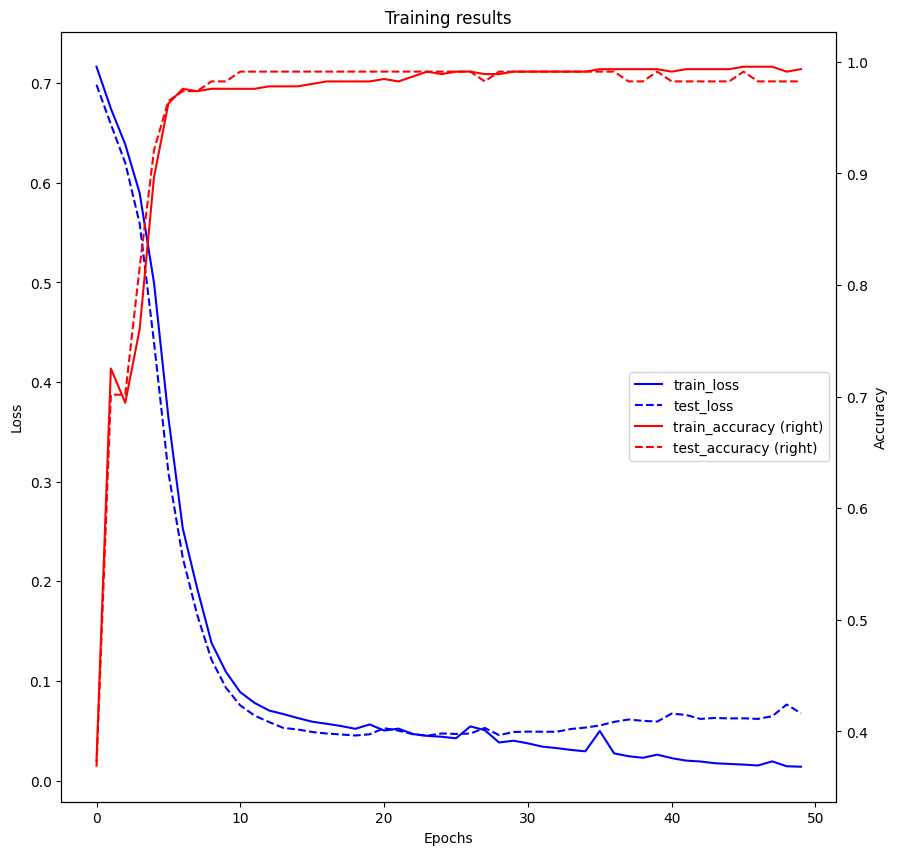

In [40]:
from visualization import plot_training
plot_training(res)

In [41]:
states[0]

OrderedDict([('l1.weight',
              tensor([[ 0.1224,  0.0859,  0.0385, -0.0956,  0.0569,  0.1628, -0.0186,  0.0721,
                        0.0811,  0.0987, -0.1517,  0.0510, -0.0459, -0.0066,  0.1188,  0.0234,
                        0.1179,  0.1575, -0.0625, -0.1773,  0.0336,  0.1756,  0.1475,  0.1186,
                        0.1091, -0.1253, -0.0098, -0.0084,  0.0148, -0.1692],
                      [ 0.0342,  0.0582,  0.1556, -0.0709, -0.0764, -0.1306,  0.1688, -0.0155,
                        0.0275,  0.0615, -0.0898,  0.1459, -0.0637,  0.1687,  0.0247,  0.0580,
                        0.1357, -0.0083,  0.1638, -0.1684, -0.1485,  0.0274,  0.0710, -0.1158,
                       -0.0865, -0.0157, -0.0013, -0.0007,  0.0241, -0.0807],
                      [ 0.0638,  0.1573, -0.1289,  0.1743, -0.1792,  0.0319, -0.0735,  0.1627,
                        0.1319, -0.1714,  0.0919,  0.1780, -0.1539, -0.1741,  0.1690,  0.1182,
                        0.1591, -0.0567,  0.0744, -0.0246

In [42]:
# import torch
ncounts_per_epoch = {}
total_times = []
building_times = []
passing_times = []
for epoch in [0,15,49]:
    start = time.time()
    # state_dict = torch.load(states[epoch])
    tree = RegionTree(states[epoch])
    tree.build_tree(verbose=False, check_feasibility=True)
    intermediate = time.time()
    tree.pass_dataloader_through_tree(train_data)
    tree.collect_number_counts()
    ncounts_per_epoch[epoch] = tree.get_number_counts()
    # print(tree.size)
    end = time.time()
    total_time = end-start
    building_time = intermediate-start
    passing_time = end-intermediate
    
    total_times.append(total_time)
    building_times.append(building_time)
    passing_times.append(passing_time)
    print(f"\nEpoch: {epoch}")
    print(f"Total time taken:    {total_time:.3f} s")
    print(f"Time building:       {building_time:.3f} s")
    print(f"Time passing:        {passing_time:.3f} s")
total_time = sum(total_times)




Epoch: 0
Total time taken:    325.948 s
Time building:       325.808 s
Time passing:        0.140 s

Epoch: 15
Total time taken:    311.302 s
Time building:       310.853 s
Time passing:        0.448 s

Epoch: 49
Total time taken:    362.747 s
Time building:       362.594 s
Time passing:        0.154 s


In [43]:
print(total_time)

999.9971745014191


In [48]:
e0 = ncounts_per_epoch[49]

In [52]:
print(len(e0))
print(len(e0[e0["total"]>0]))

20511
340


In [53]:
from src_experiment import DivergenceEngine, QUANTITIES_TO_ESTIMATE
from typing import Dict, List
class EstimateQuantities1Run:
    """
    Experiment-specific wrapper that:
    - loads number counts
    - loops over epochs
    - delegates all math to DivergenceEngine
    """

    def __init__(
        self,
        ncounts
    ):
        self.ncounts = ncounts

        self.estimates: Dict[str, List[pd.DataFrame]] = {
            q: [] for q in QUANTITIES_TO_ESTIMATE
        }

        # Perform calculations
        self.calculate_estimates()

    # ------------------------------------------------------------------

    def calculate_estimates(self) -> None:
        for epoch, frame in self.ncounts.items():
            engine = DivergenceEngine(frame)
            epoch_results = engine.compute()

            for key, df in epoch_results.items():
                df.insert(0, "epoch", epoch)
                self.estimates[key].append(df)

        # Concatenate epochs
        for key, frames in self.estimates.items():
            self.estimates[key] = (
                pd.concat(frames, ignore_index=True)
                .rename_axis(None, axis=1)
            )

    def get_estimates(self) -> Dict[str, pd.DataFrame]:
        return self.estimates


In [54]:
est1 = EstimateQuantities1Run(ncounts_per_epoch)

/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:117: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / self.m_w
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m

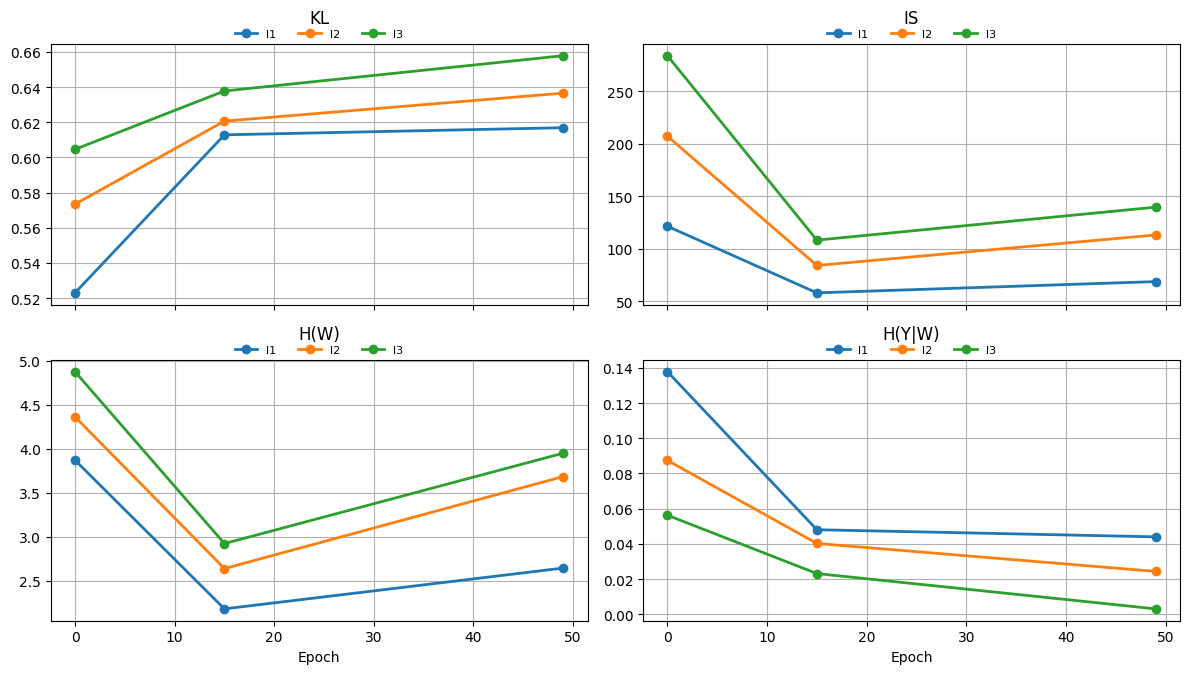

In [55]:
from visualization import plot_all_quantities
plot_all_quantities(est1.get_estimates())